# Optimisation PC1 :  Charge d'une flotte de véhicules électriques


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

## Partie II : Etude et résolution numérique

1)   On étudie le problème donné en correction dans le cas d'une seule voiture, de fonction à minimiser $f : \omega \longrightarrow p^T \times \omega $ sous les contraintes :

$$c_1 : \omega \longrightarrow - \omega$$

$$c_2 : \omega \longrightarrow \omega - \omega_{max}$$

$$c_3 : \omega \longrightarrow (\Delta q - b_0 1_{[n_0,n_f]}^T \omega) \times (\Delta q + b_0 1_{[n_0,n_f]}^T \omega)$$

Les contraintes $c_1$ et $c_2$  bornent $\omega$ : $ \omega \in [0,\omega_{max}]$. De plus $f$ est linéaire 
et convexe et la recherche du minimum se fait sur un fermé borné, donc le problème admet un minimum global. 
En revanche, $f$ étant linéaire donc pas $\alpha$-convexe, on ne peut pas conclure sur l'unicité du minimum. 
Pour la recherche du min, on s'oriente donc vers un algorithme d'Uzawa. 

2) On cherche les ordres de grandeur. Pour commencer, nous allons échantillonner sur une journée; imaginons que nous voulons un échantillon par minute environ, nous prenons N = 1500 échantillons (les valeurs actuelles du plot sont calculées avec un échantillonages de 500 pour accélérer l'algorithme)

Sur Paris, les heures creuses sont de 23h (échantillon 1437) à 7h (échantillon 438), à 0.123 euros, et les heures pleines sont à 0.1580 euros. 

On part sur un véhicule qui sera déposé à 19h (échantillon 1188) et récupéré à 22h (échantillon 1375), avec un SOCi de 50% et un SOCf de 70%. Comme nous avons trovué une charge maximale valant $q_{max}=520 \times 230$ V, la capacité étant de 520 Ah, on peut donc en déduire $\Delta Q = q_{max} \times \Delta SOC$ kWh

Dans le cadre d'un problème de rechargement d'un seul véhicule, la puissance limite qui compte est celle supportée par la batterie soit 50 kW. Pour un problème à plusieurs véhicules, la puissance limitante est celle du réseau soit 150 kW pour une borne de rechargement rapide du protocole CHAdeMO.

### Implémentation de l'algorithme d'Uzawa

On considère que le lagrangien vaut :

$$ \mathcal{L}(w,\lambda) = p^T
\begin{pmatrix} 
w_1 \\
\dots \\
w_N
\end{pmatrix}
+ \lambda^T
\begin{pmatrix} 
    -\vec{w} \\ 
    \vec{w}-w_{max} \\
    (\frac{\Delta Q}{b_0}-1^T\vec{w})(\frac{\Delta Q}{b_0}+1^T\vec{w})
\end{pmatrix}
$$

In [2]:
#ta,tb,ti,tf = 438, 1437, 1188, 1499
ta,tb,ti,tf = 140, 450, 300, 498
pmin, pmax = 0.123, 0.158
wmax = 50000
#N = 1500
N = 500
p = np.zeros(N)
p[0:ta] = pmin
p[ta:tb]=pmax
p[tb:1500] = pmin
Id = np.zeros(N)
Id[ti:tf] = 1
DeltaQ = 35190
b0 = 1/230
w0 = np.ones(N)/DeltaQ

def fun(wk):
    return np.dot(p,wk)

def c(wk):
    res= np.zeros(2*N+1)
    res[:N]=np.array(-wk)
    res[N:2*N]=np.array(wk-wmax)
    res[-1]=(DeltaQ/b0-np.dot(Id,wk))*(DeltaQ/b0+np.dot(Id,wk))
    return res

def grad_fun(wk):
    return p
    
def grad_c(wk):
    grad = np.zeros((2*N+1,N))
    for i in range(N):
        grad[i,i] = -1
    for i in range(N,2*N):
        grad[i,i-N] = 1
    grad[2*N,:] = -2*Id*wk
    return grad
    
def uzawa(fun, grad_fun, c, grad_c, w0, l=0.0001, rho=0.0001, lambda0 = np.ones(2*N+1), max_iter = 10000, epsilon = 1e-5 ):
    debut = time.time()
    k = 0
    wk = w0
    lambdak = lambda0
    grad_lagrangien_wk = grad_fun(wk) + np.dot(lambdak,grad_c(wk))
    while (k < max_iter) and (np.linalg.norm(wk[ti-100])>epsilon):
        grad_lagrangien_wk = grad_fun(wk) + np.dot(lambdak,grad_c(wk))
        pk = - grad_lagrangien_wk
        wk = wk + l*pk
        lambdak = np.maximum(0, lambdak + rho*c(wk))
        k += 1
    fin = time.time()
    print("Temps d'exécution : ", fin-debut)
    print("Nombre d'itérations : ", k )
    print(b0*np.sum(wk)-DeltaQ)
    return wk

wk=uzawa(fun, grad_fun, c, grad_c, w0, max_iter = 1000)



Temps d'exécution :  5.263622999191284
Nombre d'itérations :  1000
39580477.297952764


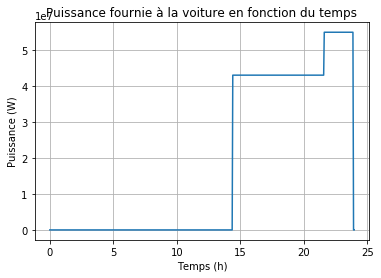

In [3]:
plt.plot(np.arange(N)/500*24,wk)
plt.grid()
plt.title("Puissance fournie à la voiture en fonction du temps")
plt.xlabel("Temps (h)")
plt.ylabel("Puissance (W)")
plt.show()

On constate que la contrainte qui pose problème est a priori celle de la satisfaction de la demande du client puisque l'algorithme ne se limite pas en puissance consommée. La contrainte de $w_{max}$ n'est elle non plus pas respectée et celle de la positivité de $w$ ne l'est pas ponctuellement.

De même, une explosion en temps est visible dès le début de l'algorithme avec le gradient du lagrangien qui atteint une valeur de l'ordre de $10^4$ dès la deuxième itération qui traduit de nouveau un problème dans la définition des contraintes.

Néanmoins, l'allure de la puissance obtenue est logique vis a vis du problème. En effet, la courbe est effectivement nulle en dehors de l'intervalle de temps où la voiture est branchée à la borne et on a bien deux paliers de puissance, un plus faible à l'endroit où le prix est plus important et un palier de valeurs plus élévées où le prix de l'électricité est le plus faible.

Le fait de ne pas être borné par des contraintes implique également que le maximum d'itération est systématiquement atteint puisque la fonction objectif est toujours croissante.


## Partie III : Etude avancée

On étudie le problème donné en correction dans le cas de nv véhicules, de fonction à minimiser $\sum_{i=1}^{n_v} p^T \times \omega_i $ avec $\omega_i \in \mathbb{R}^N, i \in |[  1, n_v ]| $ sous les contraintes : 

$$c_{1,i} : \omega_i \longrightarrow - \omega_i, i \in |[ 1, n_v ]| $$

$$c_{2} : \omega_i \longrightarrow \sum_{i=1}^{n_v}\omega - \omega_{max}, , i \in |[  1, n_v ]|$$

$$c_{3,i} : \omega_i \longrightarrow (\Delta q_i - b_0 1_{(n_{i,0},n_{i,f})}^T \omega_i) \times (\Delta q_i + b_0 1_{(n_0,n_f)}^T \omega_i)$$

On est donc bien dans le cas où le coût se décompose en une somme de termes dépendant de variables indépendantes les unes des autres (les $\omega_i$) : le coût est une somme de fonctions $f_i \longrightarrow p^T \times \omega_i$. De plus, on peut décomposer deux des trois contraintes en une somme de contraintes dépendant de variables de décisions indépendants : pour $c_{1,i}$ et $c_{3,i}$ les termes dépendant de $\omega_k$ sont nuls sauf pour $k=i$. En revanche, la contrainte $c_2$ pose davantage de problème car on ne peut pas le décomposer de la sorte. Si on souhaite néanmoins appliquer l'algorithme de décomposition/coordination, il faut prendre 

Dans le cas où on a deux véhicules :
$$c(\vec{w_1},\vec{w_2}) = 
\begin{pmatrix}
-\vec{w_1} \\
-\vec{w_2} \\
\vec{w_1}+\vec{w_2}-w_{max} \\
(\frac{\Delta Q}{b_0}-1^T\vec{w_1})(\frac{\Delta Q}{b_0}+1^T\vec{w_1}) \\
(\frac{\Delta Q}{b_0}-1^T\vec{w_2})(\frac{\Delta Q}{b_0}+1^T\vec{w_2})
\end{pmatrix}
= \begin{pmatrix}
-\vec{w_1} \\
0 \\
\vec{w_1} \\
(\frac{\Delta Q}{b_0}-1^T\vec{w_1})(\frac{\Delta Q}{b_0}+1^T\vec{w_1}) \\
0
\end{pmatrix}
+ 
\begin{pmatrix}
0 \\
-\vec{w_2} \\
\vec{w_2}-w_{max} \\
0 \\
(\frac{\Delta Q}{b_0}-1^T\vec{w_2})(\frac{\Delta Q}{b_0}+1^T\vec{w_2})
\end{pmatrix}
$$

In [6]:
   ti1,tf1, ti2, tf2 = 300, 498, 100,310
Id1 , Id2= np.zeros(N), np.zeros(N)
Id1[ti1:tf1] = 1
Id2[ti2:tf2] = 1

def c1(wk):
    res= np.zeros(3*N + 2)
    res[:N]=np.array(-wk)
    res[2*N:3*N]=np.array(wk)
    res[-2]=(DeltaQ/b0-np.dot(Id1,wk))*(DeltaQ/b0+np.dot(Id1,wk))
    return res

def grad_c1(wk):
    grad = np.zeros((3*N+2,N))
    for i in range(N):
        grad[i,i] = -1
    for i in range(2*N,3*N):
        grad[i,i-2*N] = 1
    grad[3*N,:] = -2*Id1*wk
    return grad

def c2(wk):
    res= np.zeros(3*N+2)
    res[N:2*N]=np.array(-wk)
    res[2*N:3*N]=np.array(wk-wmax)
    res[-1]=(DeltaQ/b0-np.dot(Id2,wk))*(DeltaQ/b0+np.dot(Id2,wk))
    return res

def grad_c2(wk):
    grad = np.zeros((3*N + 2,N))
    for i in range(N,2*N):
        grad[i,i-N] = -1
    for i in range(2*N,3*N):
        grad[i,i-2*N] = 1
    grad[3*N + 1,:] = -2*Id2*wk
    return grad
    

def decomposition_coordination(fun, grad_fun, c1, grad_c1, c2, grad_c2, w0, 
                               l=0.0001, rho=0.0001, lambda0=np.ones(3*N +2), max_iter=1000, epsilon=1e-8):
    debut = time.time()
    k = 0
    wk = w0
    lambdak = lambda0
    wk1 = uzawa(fun, grad_fun, c1, grad_c1, w0, lambda0 = np.ones(3*N+2))
    wk2 = uzawa(fun, grad_fun, c2, grad_c2, w0, lambda0 = np.ones(3*N+2))
    lambdak1 = max(0, lambdak + rho*(c1(wk1)) + c2(wk2))
    while (k < max_iter) and (np.linalg.norm(lambdak1-lambdak)>epsilon):
        lambdak=lambdak1
        wk1 = np.array(uzawa(fun, grad_fun, c1, grad_c1, w0, lambda0 = lambdak))
        wk2 = np.array(uzawa(fun, grad_fun, c2, grad_c2, w0, lambda0 = lambdak))
        lambdak1= max(0, lambdak + rho*(c1(wk1)) + c2(wk2))
        k+=1
    fin = time.time()
    print("Temps d'exécution : ", fin-debut)
    print("Nombre d'itérations : ", k )
    return wk1,wk2

wsol = decomposition_coordination(fun, grad_fun, c1, grad_c1, c2, grad_c2, w0)

plt.plot(np.arange(N)/500*24, wsol[0], label='Voiture 1')
plt.plot(np.arange(N)/500*24, wsol[1], label='Voiture 2')
plt.title("Puissance fournie à chacune des voitures en fonction du temps")
plt.xlabel("Temps (h)")
plt.ylabel("Puissance (W)")
plt.legend()
plt.show()
        

Temps d'exécution :  0.03299522399902344
Nombre d'itérations :  2
-35174.80600179501
Temps d'exécution :  83.99602580070496
Nombre d'itérations :  10000
22501588.117815673


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Il y a une erreur dans l'algorithme qui provient peut-être des défaillances de la partie précédente.